In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import cv2
import numpy as np
from utils import *
from extractor import Extractor
import matplotlib.pyplot as plt

In [4]:
fe=Extractor()

In [139]:
def projected_map(kps,depth):
    for p in kps:
        u,v=map(lambda x: int(round(x)),p.pt)
        Z=depth[v,u]
        # print(u,v,Z)

    


In [158]:

def process_img(img,depth):
    matches=fe.extract(img)
    ransac(matches)
    # print(matches[:-1][0])
    
    # projected_map(matches,depth)
    for kp1,kp2 in matches:
        u1,v1=map(lambda x: int(round(x)),kp1)
        u2,v2=map(lambda x: int(round(x)),kp2)
        cv2.circle(img,(u1,v1),color=(0,255,0),radius=3)
        cv2.line(img,(u1,v1),(u2,v2),color=(255,0,0))
        disp(img,"RGB")




In [174]:
if __name__ == "__main__":
    
    depth_paths='../rgbd_dataset_freiburg1_xyz/depth.txt'
    dlist=data(depth_paths)

    rgb_paths='../rgbd_dataset_freiburg1_xyz/rgb.txt'
    ilist=data(rgb_paths)

    dataset_path='../rgbd_dataset_freiburg1_xyz/'
    

    for i in range(len(dlist)):

        frame=cv2.imread(dataset_path+ilist[i])
        depth=cv2.imread(dataset_path+dlist[i],0)
        # print(frame.shape,depth.shape)


        process_img(frame,depth)
        # print(frame)

        if frame is None:
            print("End of frame")
            break

        
        disp(depth,"Depth")
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


        


[[199. 185.]
 [127. 357.]
 [301. 191.]
 [522.  35.]
 [204. 201.]
 [ 98. 183.]
 [193. 211.]
 [212. 418.]
 [140. 253.]
 [214. 194.]
 [199. 381.]
 [200. 389.]
 [273. 307.]
 [151. 412.]
 [ 95. 194.]
 [128. 350.]
 [206. 399.]
 [256. 208.]
 [286. 260.]
 [ 97. 214.]
 [133. 342.]
 [289.  94.]
 [135.  57.]
 [302. 186.]
 [129. 368.]
 [201. 410.]
 [116. 288.]
 [238. 186.]
 [262. 179.]
 [247. 174.]
 [285. 238.]
 [117. 272.]
 [250. 213.]
 [132. 252.]
 [112. 278.]
 [131. 246.]
 [235. 233.]
 [162. 221.]
 [102. 204.]
 [269. 185.]
 [277. 202.]
 [133. 312.]
 [ 76. 255.]
 [ 87. 199.]
 [490. 278.]
 [302. 267.]
 [139. 189.]
 [ 89. 291.]
 [138. 397.]
 [106. 183.]
 [ 81. 193.]
 [ 79. 182.]
 [267. 317.]
 [120. 326.]
 [ 80. 254.]
 [107. 359.]
 [195. 402.]
 [112. 387.]
 [178. 338.]
 [141. 307.]
 [138. 340.]
 [354. 129.]
 [104. 395.]
 [589.  71.]
 [ 86. 195.]
 [ 87. 254.]
 [100. 253.]
 [109. 401.]
 [172. 214.]
 [218. 421.]
 [ 86. 421.]
 [387. 313.]
 [ 47. 319.]
 [586. 414.]
 [345. 130.]
 [386. 310.]
 [104. 344.]

In [22]:
from transformation import *

In [41]:
class RANSAC:
    def __init__(self,matches,model,n,th,iter):
        coordinate_array=np.array(matches)
        self.kp1=coordinate_array[:,0,:].T
        self.kp2=coordinate_array[:,1,:].T
        
        self.sample=n
        self.threshold=th
        self.iter=iter
        self.model=model
    
    def solve(self):
        i=0
        best_inlier=0
        best_params={}
        # T=(1-self.eta)*self.pt1.shape[1]
        # print(T)
        while(i<self.iter):

            #select random sample
            # print(self.pt1.shape[1])

            idxs=np.random.randint(0,self.kp1.shape[1],size=self.sample) 
                  
            
            pts1=self.kp1[:,idxs]
            pts2=self.kp2[:,idxs]

            #compute model parameter
            
            self.model.compute_parameter(pts1,pts2)
            
            #calculate the reprojection error
            error=self.model.error(self.kp1,self.kp2)

            if error is None:
                continue
            
            mask=error<self.threshold 
            
                    
            if (np.sum(mask)>np.sum(best_inlier)):
                # print(np.sum(mask))  
                best_params=self.model.params
                best_inlier=mask
            # if (np.sum(mask)>T):
            #     break
        
                

            # print(inliers_pts1.size)
            i+=1
        
        return best_params,best_inlier,np.sum(error)
        # plt.show()


In [12]:
# def ransac(matches):
#     coordinate_array=np.array(matches)
#     kp1=coordinate_array[:,0,:].T
#     kp2=coordinate_array[:,1,:].T


    
#     # print(kp1,kp2)
#     params,error=transformation(kp1,kp2)
#     # print(error)
#     return(params)
    


In [13]:


matches = [((1, 2), (3, 4)), ((5, 6), (7, 8)), ((9, 10), (11, 12))]
# ransac(matches)

In [89]:
th=np.pi*0/180.0

# R1=np.array([[np.cos(th),-np.sin(th),0],
#             [np.sin(th),np.cos(th),0],
#             [0,0,1]])
R1=np.array([[np.cos(th),-np.sin(th)],
            [np.sin(th),np.cos(th)]])
            

c1=1
t1=np.array([100,0]).T

# kp1=np.array([[1,2,3],[5,6,7]])
kp1=50*np.random.rand(2,100)




matches=[]
for i in range(kp1.shape[1]):
    k1=kp1[:,i]
    # k1 = tuple(k1)
    noise=np.random.rand(2)
    k2=c1*np.dot(R1,kp1[:,i])+t1+noise
    # print(k2.shape,noise.shape)
    # k2 = tuple(k2)
    matches.append((k1,k2))

# print(matches)




# params=ransac(matches)
# print(params['c'])



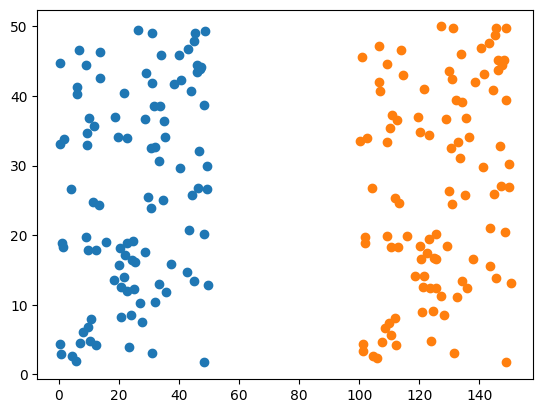

In [90]:
coordinate_array=np.array(matches)
kp1=coordinate_array[:,0,:].T
kp2=coordinate_array[:,1,:].T

plt.scatter(kp1[0,:],kp1[1,:])
plt.scatter(kp2[0,:],kp2[1,:])
plt.show()

T=Transformation()
T.compute_parameter(kp1,kp2)
error=T.error(kp1,kp2)
# print(error)

In [7]:
R2=params['R']
t2=params['t']
c2=params['c']


matches2=[]

for i in range(kp1.shape[1]):
    k1=kp1[:,i]
    k1 = tuple(k1)
    k2=c2*np.dot(R2,kp1[:,i])+t2
    k2 = tuple(k2)
    matches2.append((k1,k2))
print(R2)

[[ 8.66025404e-01 -5.00000000e-01  3.32589284e-16]
 [ 5.00000000e-01  8.66025404e-01  3.65068883e-16]
 [-4.56226080e-16  7.97984205e-16  1.00000000e+00]]


In [93]:
ransac=RANSAC(matches,T,3,0.5,100)
best_params,best_inlier,error=ransac.solve()


In [94]:
R2=best_params['R']
t2=best_params['t']
c2=best_params['c']


matches2=[]
for i in range(kp1.shape[1]):
    k1=kp1[:,i]
    # k1 = tuple(k1)
    noise=np.random.rand(2)
    k2=c2*np.dot(R2,kp1[:,i])+t2.reshape(2)
    # print(k2.shape,t2.shape)
    # k2 = tuple(k2)
    matches2.append((k1,k2))


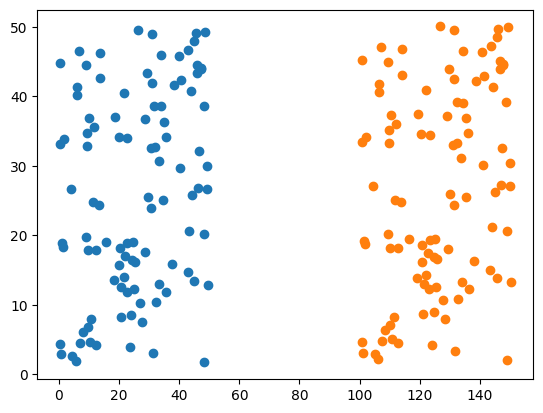

In [95]:
coordinate_array=np.array(matches2)
kp1=coordinate_array[:,0,:].T
kp2=coordinate_array[:,1,:].T

plt.scatter(kp1[0,:],kp1[1,:])
plt.scatter(kp2[0,:],kp2[1,:])
plt.show()

In [96]:
print(best_params)

{'R': array([[ 0.9999963 , -0.00271925],
       [ 0.00271925,  0.9999963 ]]), 't': array([[100.46905313],
       [  0.23909838]]), 'c': 1.0049971540656797}
